**Experiment 2**

In [1]:
# Cell 1 — Install dependencies
!pip -q install opacus==1.4.0 tqdm pandas matplotlib torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 8.4 MB/s eta 0:00:00


In [2]:
# Cell 2 — Imports + reproducibility
import os, math, random
from copy import deepcopy
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt



# Wider alpha grid => avoids "optimal order is the largest alpha" warning
RDP_ALPHAS = (
    [1.01, 1.05] +
    [1.1 + 0.1*i for i in range(0, 90)] +      # 1.1..10.0
    list(range(11, 64)) + [64, 128, 256, 512]
)

def seed_all(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)


device: cuda


In [3]:
# Cell 3 — Dataset: Fashion-MNIST + loaders
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.2860,), (0.3530,))
])

train_ds = torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

test_loader = DataLoader(test_ds, batch_size=512, shuffle=False, num_workers=2, pin_memory=True)
print("train:", len(train_ds), "test:", len(test_ds))


100%|██████████| 26.4M/26.4M [00:02<00:00, 10.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 204kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.85MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 37.6MB/s]

train: 60000 test: 10000


In [4]:
# Cell 4 — Create IID clients (6000 clients × 10 samples/client)
def build_iid_clients(num_clients=6000, samples_per_client=10, seed=0):
    assert num_clients * samples_per_client <= len(train_ds)
    rng = np.random.default_rng(seed)
    all_idx = rng.permutation(len(train_ds))[:num_clients * samples_per_client]
    return [all_idx[i*samples_per_client:(i+1)*samples_per_client].tolist()
            for i in range(num_clients)]

NUM_CLIENTS = 6000
CLIENTS_PER_ROUND = 100
SAMPLES_PER_CLIENT = 10

clients = build_iid_clients(NUM_CLIENTS, SAMPLES_PER_CLIENT, seed=0)
print("clients:", len(clients), "samples/client:", len(clients[0]))


clients: 6000 samples/client: 10


In [5]:
# Cell 5 — Public anchor indices (public set for anchors)
# Purpose: Build a small PUBLIC dataset (DP-safe) used to generate multiple public anchors.
# Default: 20 samples/class => 200 total public points.

def extract_public_per_class(dataset, per_class=20, seed=0):
    rng = np.random.default_rng(seed)
    targets = np.array(dataset.targets)
    public_idx = []
    for k in range(10):
        cls_idx = np.where(targets == k)[0]
        rng.shuffle(cls_idx)
        public_idx.extend(cls_idx[:per_class].tolist())
    return sorted(public_idx)

PUBLIC_PER_CLASS = 30  # 20*10 = 200 public samples (set to 30 for 300, etc.)
public_idx = extract_public_per_class(train_ds, per_class=PUBLIC_PER_CLASS, seed=0)

print("public samples:", len(public_idx), f"(per_class={PUBLIC_PER_CLASS})")


public samples: 300 (per_class=30)


In [6]:
# Cell 6 — Model + evaluation
class FMNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)  # 14x14
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)  # 7x7
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        pred = model(x).argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / total


In [7]:
# Cell 7 — Tensor-list + flatten helpers
def model_param_list(model):
    return [p for p in model.parameters() if p.requires_grad]

@torch.no_grad()
def zero_like_params(model):
    return [torch.zeros_like(p.data) for p in model_param_list(model)]

@torch.no_grad()
def add_update_(model, update_list, scale=1.0):
    for p, u in zip(model_param_list(model), update_list):
        p.data.add_(u, alpha=scale)

@torch.no_grad()
def add_scaled_list_(dst, src, alpha):
    for d, s in zip(dst, src):
        d.add_(s, alpha=float(alpha))

@torch.no_grad()
def norm_sq_list(tlist):
    s = None
    for t in tlist:
        v = (t*t).sum()
        s = v if s is None else s + v
    return s + 1e-12

@torch.no_grad()
def l2_norm_list(tlist):
    return torch.sqrt(norm_sq_list(tlist))

def sub_list(a, b):
    return [x - y for x, y in zip(a, b)]

@torch.no_grad()
def dot_list(a_list, b_list):
    s = None
    for a, b in zip(a_list, b_list):
        v = (a*b).sum()
        s = v if s is None else s + v
    return s

@torch.no_grad()
def flatten_list(tlist):
    return torch.cat([t.reshape(-1) for t in tlist])

@torch.no_grad()
def unflatten_like(vec, template_list):
    out = []
    idx = 0
    for t in template_list:
        n = t.numel()
        out.append(vec[idx:idx+n].view_as(t))
        idx += n
    return out


In [8]:
# Cell 8 — Local client update (SGD) returns delta = (local - global)
loss_fn = nn.CrossEntropyLoss()

def client_update(global_model, client_indices, lr, momentum, local_epochs=1, batch_size=10):
    local_model = deepcopy(global_model).to(device)
    local_model.train()

    loader = DataLoader(Subset(train_ds, client_indices),
                        batch_size=batch_size, shuffle=True, drop_last=False)

    opt = torch.optim.SGD(local_model.parameters(), lr=lr, momentum=momentum)

    for _ in range(int(local_epochs)):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            loss = loss_fn(local_model(x), y)
            loss.backward()
            opt.step()

    delta = []
    for lp, gp in zip(model_param_list(local_model), model_param_list(global_model)):
        delta.append((lp.data - gp.data).detach())
    return delta


In [9]:
# Cell 9 — DP accounting (RDP) + sigma search (Opacus-version-proof)
# Purpose: compute epsilon for given noise multiplier(s) and binary-search sigma.

from opacus.accountants.analysis import rdp as rdp_analysis

def _compute_rdp(q, noise_multiplier, steps, orders):
    # Some versions accept kwargs, others positional; support both.
    try:
        return rdp_analysis.compute_rdp(q=q, noise_multiplier=noise_multiplier, steps=steps, orders=orders)
    except TypeError:
        return rdp_analysis.compute_rdp(q, noise_multiplier, steps, orders)

def _get_eps(orders, rdp, delta):
    try:
        eps, _ = rdp_analysis.get_privacy_spent(orders=orders, rdp=rdp, delta=delta)
    except TypeError:
        eps, _ = rdp_analysis.get_privacy_spent(orders, rdp, delta)
    return float(eps)

def epsilon_from_sigma_single(sigma, q, steps, delta):
    rdp = _compute_rdp(q, float(sigma), int(steps), RDP_ALPHAS)
    return _get_eps(RDP_ALPHAS, rdp, delta)

def epsilon_from_sigma_two(sig_sel, sig_rel, q, steps, delta):
    rdp1 = _compute_rdp(q, float(sig_sel), int(steps), RDP_ALPHAS)
    rdp2 = _compute_rdp(q, float(sig_rel), int(steps), RDP_ALPHAS)
    return _get_eps(RDP_ALPHAS, rdp1 + rdp2, delta)

def find_sigma_for_target_eps_single(target_eps, q, steps, delta, iters=50):
    lo, hi = 1e-4, 1.0
    while epsilon_from_sigma_single(hi, q, steps, delta) > target_eps:
        hi *= 2.0
        if hi > 1e4:
            raise RuntimeError("Could not find sigma upper bound. Reduce steps or increase eps.")
    for _ in range(iters):
        mid = 0.5*(lo+hi)
        if epsilon_from_sigma_single(mid, q, steps, delta) > target_eps:
            lo = mid
        else:
            hi = mid
    return float(hi)

def find_sigma_rel_for_target_eps_two(target_eps, q, steps, delta, sel_factor=2.0, iters=50):
    # sig_sel = sel_factor * sig_rel
    lo, hi = 1e-4, 1.0
    def E(sig_rel):
        return epsilon_from_sigma_two(sel_factor*sig_rel, sig_rel, q, steps, delta)

    while E(hi) > target_eps:
        hi *= 2.0
        if hi > 1e4:
            raise RuntimeError("Could not find sigma upper bound (two). Reduce steps or increase eps.")
    for _ in range(iters):
        mid = 0.5*(lo+hi)
        if E(mid) > target_eps:
            lo = mid
        else:
            hi = mid
    return float(hi)


In [10]:
# Cell 10 — ALIE attack helpers (constant-z, consistent across f)
# Purpose: ALIE strength does NOT change with Byzantine fraction.

@torch.no_grad()
def alie_attack_from_honest_constz(honest_updates, byz_count, z=2.0, direction=-1.0):
    """
    Returns byz_count malicious updates where:
        mal = mu + direction * z * std   (coordinate-wise)
    z is constant (same for all f).
    """
    if byz_count <= 0:
        return []
    if len(honest_updates) == 0:
        raise ValueError("No honest updates to build ALIE.")

    P = len(honest_updates[0])
    mal = []
    for j in range(P):
        stacked = torch.stack([u[j] for u in honest_updates], dim=0)
        mu = stacked.mean(dim=0)
        sd = stacked.std(dim=0, unbiased=False) + 1e-12
        mal.append(mu + float(direction) * float(z) * sd)

    mal = [t.detach() for t in mal]
    return [[t.clone() for t in mal] for _ in range(byz_count)]


In [11]:
# Cell 10.5 — Build R public anchors per round (8–16 anchors)
# Purpose: Replace "2 anchors only" with R public anchors + 1 zero anchor.

def public_anchor_update_on_subset(global_model, subset_indices, lr, momentum, public_epochs=1):
    local_model = deepcopy(global_model).to(device)
    local_model.train()

    loader = DataLoader(Subset(train_ds, subset_indices),
                        batch_size=len(subset_indices), shuffle=True, drop_last=False)

    opt = torch.optim.SGD(local_model.parameters(), lr=lr, momentum=momentum)

    for _ in range(int(public_epochs)):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            loss = loss_fn(local_model(x), y)
            loss.backward()
            opt.step()

    delta_pub = []
    for lp, gp in zip(model_param_list(local_model), model_param_list(global_model)):
        delta_pub.append((lp.data - gp.data).detach())
    return delta_pub

def build_public_anchors(global_model, public_indices, R, lr, momentum,
                         public_epochs=1, pub_batch=20, pub_scale=0.1, seed=0):
    """
    Returns list of R anchors. Each anchor is pub_scale * (one SGD step on a random public subset).
    """
    rng = np.random.RandomState(seed)
    anchors = []
    for r in range(R):
        k = min(int(pub_batch), len(public_indices))
        subset = rng.choice(public_indices, size=k, replace=False).tolist()
        delta_pub = public_anchor_update_on_subset(global_model, subset, lr, momentum, public_epochs=public_epochs)
        anchors.append([pub_scale * d for d in delta_pub])
    return anchors


In [12]:
# Cell 11 — DP-FedAvg robust under ALIE (constant-z)
def train_dp_fedavg_robust(seed, eps_total, byz_frac,
                           sigma, delta=1e-5,
                           num_clients=NUM_CLIENTS, clients_per_round=CLIENTS_PER_ROUND,
                           rounds=30, local_epochs=10, batch_size=10,
                           lr0=0.125, lr_decay=0.99, momentum=0.5,
                           clip_C=1.0,
                           alie_direction=-1.0, alie_z=2.0):

    seed_all(seed)
    rng = np.random.RandomState(seed)
    model = FMNIST_CNN().to(device)

    for t in tqdm(range(rounds), desc=f"DP-FedAvg f={int(100*byz_frac)}%"):
        lr_t = lr0 * (lr_decay ** t)
        chosen = rng.choice(num_clients, size=clients_per_round, replace=False)

        b = int(round(byz_frac * clients_per_round))
        byz_pos = set(rng.choice(clients_per_round, size=b, replace=False)) if b>0 else set()

        honest_updates = []
        for j, cid in enumerate(chosen):
            if j in byz_pos:
                continue
            honest_updates.append(
                client_update(model, clients[cid], lr=lr_t, momentum=momentum,
                              local_epochs=local_epochs, batch_size=batch_size)
            )

        byz_updates = alie_attack_from_honest_constz(honest_updates, b, z=alie_z, direction=alie_direction) if b>0 else []

        sum_update = zero_like_params(model)

        for upd in honest_updates + byz_updates:
            nrm = l2_norm_list(upd).item()
            scale = min(1.0, clip_C/(nrm + 1e-12))
            add_scaled_list_(sum_update, upd, scale)

        for j in range(len(sum_update)):
            sum_update[j].add_(torch.randn_like(sum_update[j]) * (sigma * clip_C))

        avg_update = [u / clients_per_round for u in sum_update]
        add_update_(model, avg_update, scale=1.0)

    acc = evaluate(model, test_loader)
    return acc


In [13]:
# Cell 12 — AG-PTR robust (R public anchors + zero), accept ONLY if public wins
def train_ag_ptr_robust(seed, eps_total, byz_frac,
                        sigma_sel, sigma_rel, delta=1e-5,
                        num_clients=NUM_CLIENTS, clients_per_round=CLIENTS_PER_ROUND,
                        rounds=30, local_epochs=10, batch_size=10,
                        lr0=0.125, lr_decay=0.99, momentum=0.5,
                        rho=0.79, tau=60,
                        # anchors
                        R=8, pub_batch=20, pub_scale=0.1, public_epochs=1,
                        # ALIE constant-z
                        alie_direction=-1.0, alie_z=2.0):

    seed_all(seed)
    rng = np.random.RandomState(seed)
    model = FMNIST_CNN().to(device)

    zero_anchor = zero_like_params(model)
    accept = 0

    for t in tqdm(range(rounds), desc=f"AG-PTR(pub-only) f={int(100*byz_frac)}%"):
        lr_t = lr0 * (lr_decay ** t)
        chosen = rng.choice(num_clients, size=clients_per_round, replace=False)

        b = int(round(byz_frac * clients_per_round))
        byz_pos = set(rng.choice(clients_per_round, size=b, replace=False)) if b>0 else set()

        # Build R public anchors for this round (DP-safe: public only)
        anchors_pub = build_public_anchors(
            model, public_idx, R=R, lr=lr_t, momentum=momentum,
            public_epochs=public_epochs, pub_batch=pub_batch, pub_scale=pub_scale,
            seed=seed*100000 + t
        )
        anchors = anchors_pub + [zero_anchor]
        K = len(anchors)
        zero_idx = K - 1

        # Honest updates
        honest_updates = []
        honest_slots = []
        for j, cid in enumerate(chosen):
            if j in byz_pos:
                continue
            honest_updates.append(
                client_update(model, clients[cid], lr=lr_t, momentum=momentum,
                              local_epochs=local_epochs, batch_size=batch_size)
            )
            honest_slots.append(j)

        # Byzantine updates (constant-z ALIE)
        byz_updates = alie_attack_from_honest_constz(honest_updates, b, z=alie_z, direction=alie_direction) if b>0 else []

        # Rebuild deltas list length M
        deltas = [None]*clients_per_round
        for upd, j in zip(honest_updates, honest_slots):
            deltas[j] = upd
        kk = 0
        for j in range(clients_per_round):
            if j in byz_pos:
                deltas[j] = byz_updates[kk]; kk += 1

        # Phase 1: assign to nearest anchor (Euclidean via dot products)
        anchor_norms = [norm_sq_list(a).item() for a in anchors]
        counts = np.zeros(K, dtype=int)
        assign = []

        for dlt in deltas:
            d0 = norm_sq_list(dlt).item()
            best_r, best_dist = 0, float("inf")
            for r in range(K):
                dist = d0 + anchor_norms[r] - 2.0 * dot_list(dlt, anchors[r]).item()
                if dist < best_dist:
                    best_dist = dist
                    best_r = r
            assign.append(best_r)
            counts[best_r] += 1

        # DP noisy selection
        noisy_counts = counts.astype(float) + rng.normal(0.0, sigma_sel, size=K)
        r_star = int(np.argmax(noisy_counts))
        noisy_winner = float(noisy_counts[r_star])

        # Fix B: accept ONLY if public anchor wins + passes tau
        if r_star == zero_idx:
            continue
        if noisy_winner < tau:
            continue

        accept += 1
        a_star = anchors[r_star]

        # Phase 2: anchored mean with rho clipping + DP noise
        sum_offsets = zero_like_params(model)
        for dlt, r_i in zip(deltas, assign):
            if r_i != r_star:
                continue
            offset = sub_list(dlt, a_star)
            off_norm = l2_norm_list(offset).item()
            scale = min(1.0, rho/(off_norm + 1e-12))
            add_scaled_list_(sum_offsets, offset, scale)

        m_hat = max(float(tau), noisy_winner)

        for j in range(len(sum_offsets)):
            sum_offsets[j].add_(torch.randn_like(sum_offsets[j]) * (sigma_rel * rho))

        mean_update = [a + (so / m_hat) for a, so in zip(a_star, sum_offsets)]
        add_update_(model, mean_update, scale=1.0)

    acc = evaluate(model, test_loader)
    accept_rate = accept / rounds
    return acc, accept_rate


In [14]:
# Cell 13 — FedVRDP robust (server-side DP noise) + constant-z ALIE
@torch.no_grad()
def topk_mask_from_vec(vec, k):
    d = vec.numel()
    k = min(int(k), d)
    mask = torch.zeros(d, device=vec.device)
    if k > 0:
        idx = torch.topk(vec.abs(), k, sorted=False).indices
        mask[idx] = 1.0
    return mask

def train_fedvrdp_robust(seed, eps_total, byz_frac,
                         sigma, delta=1e-5,
                         num_clients=NUM_CLIENTS, clients_per_round=CLIENTS_PER_ROUND,
                         rounds=30, local_epochs=10, batch_size=10,
                         lr0=0.125, lr_decay=0.99, momentum=0.5,
                         clip_C=1.0, k_frac=0.3,
                         alie_direction=-1.0, alie_z=2.0):

    seed_all(seed)
    rng = np.random.RandomState(seed)
    model = FMNIST_CNN().to(device)

    template = zero_like_params(model)
    d = sum(t.numel() for t in template)
    k = max(1, int(k_frac * d))

    # init mask (start with all-ones for stability, then update)
    mask = torch.ones(d, device=device)

    for t in tqdm(range(rounds), desc=f"FedVRDP f={int(100*byz_frac)}%"):
        lr_t = lr0 * (lr_decay ** t)
        chosen = rng.choice(num_clients, size=clients_per_round, replace=False)

        b = int(round(byz_frac * clients_per_round))
        byz_pos = set(rng.choice(clients_per_round, size=b, replace=False)) if b>0 else set()

        # honest updates (masked+clipped, NO DP noise here)
        honest_vecs = []
        honest_slots = []

        for j, cid in enumerate(chosen):
            if j in byz_pos:
                continue

            dlt = client_update(model, clients[cid], lr=lr_t, momentum=momentum,
                                local_epochs=local_epochs, batch_size=batch_size)
            v = flatten_list(dlt).to(device) * mask

            nrm = torch.norm(v) + 1e-12
            v = v * min(1.0, clip_C / float(nrm))

            honest_vecs.append(v)
            honest_slots.append(j)

        # ALIE malicious update in masked space (constant-z)
        if b > 0:
            if len(honest_vecs) == 0:
                mal = torch.zeros(d, device=device)
            else:
                mats = torch.stack(honest_vecs, dim=0)
                mu = mats.mean(dim=0)
                sd = mats.std(dim=0, unbiased=False) + 1e-12
                mal = mu + float(alie_direction) * float(alie_z) * sd
                mal = mal * mask
                nrm = torch.norm(mal) + 1e-12
                mal = mal * min(1.0, clip_C / float(nrm))
            byz_vecs = [mal.clone() for _ in range(b)]
        else:
            byz_vecs = []

        # rebuild all updates
        updates = [None]*clients_per_round
        for v, j in zip(honest_vecs, honest_slots):
            updates[j] = v
        kk = 0
        for j in range(clients_per_round):
            if j in byz_pos:
                updates[j] = byz_vecs[kk]; kk += 1

        # aggregate SUM then add DP noise (server-side, like DP-FedAvg)
        sum_vec = torch.stack(updates, dim=0).sum(dim=0)
        sum_vec = sum_vec + torch.randn_like(sum_vec) * (sigma * clip_C) * mask
        avg_vec = sum_vec / clients_per_round

        # apply update
        avg_list = unflatten_like(avg_vec, template)
        add_update_(model, avg_list, scale=1.0)

        # update mask based on update magnitude (Top-k of avg update)
        mask = topk_mask_from_vec(avg_vec.detach(), k)

    acc = evaluate(model, test_loader)
    return acc


In [15]:
# Cell 13.5 — SHORT diagnostic runs (fast) to tune tau/rho/pub_scale and check FedVRDP learns

def quick_agptr_calibrate(f=0.0, rounds=20, local_epochs=2, eps_total=2.0, delta=1e-5,
                          R_list=(8,16), tau_list=(50,60,70), rho_list=(0.6,0.79,1.0),
                          pub_scale_list=(0.05,0.1,0.2), pub_batch=20, seed=0):
    q = CLIENTS_PER_ROUND / NUM_CLIENTS
    sigma_rel = find_sigma_rel_for_target_eps_two(eps_total, q, rounds, delta, sel_factor=2.0)
    sigma_sel = 2.0 * sigma_rel

    rows = []
    for R in R_list:
        for tau in tau_list:
            for rho in rho_list:
                for ps in pub_scale_list:
                    acc, ar = train_ag_ptr_robust(
                        seed, eps_total, f, sigma_sel, sigma_rel, delta=delta,
                        rounds=rounds, local_epochs=local_epochs, batch_size=10,
                        rho=rho, tau=tau,
                        R=R, pub_batch=pub_batch, pub_scale=ps,
                        alie_z=2.0
                    )
                    rows.append({"f": f, "R": R, "tau": tau, "rho": rho, "pub_scale": ps,
                                 "acc": acc, "accept_rate": ar})
    return pd.DataFrame(rows).sort_values(["acc","accept_rate"], ascending=False)

def quick_fedvrdp_check(rounds=30, local_epochs=2, eps_total=2.0, delta=1e-5, seed=0):
    q = CLIENTS_PER_ROUND / NUM_CLIENTS
    sigma = find_sigma_for_target_eps_single(eps_total, q, rounds, delta)
    acc = train_fedvrdp_robust(seed, eps_total, 0.0, sigma, delta=delta,
                               rounds=rounds, local_epochs=local_epochs, batch_size=10,
                               clip_C=1.0, k_frac=0.3)
    return sigma, acc

# Example usage:
# df_clean = quick_agptr_calibrate(f=0.0)
# df_attack = quick_agptr_calibrate(f=0.2)
# display(df_clean.head(10))
# display(df_attack.head(10))
# print("FedVRDP check:", quick_fedvrdp_check())


In [16]:
# Cell 14 — Smoke test (small run to confirm everything works) [UPDATED]
seed = 0
eps_total = 2.0
delta = 1e-5
f = 0.20

# FAST settings (just to verify code)
ROUNDS = 5
LOCAL_EPOCHS = 1
BATCH_SIZE = 10

# Shared training hyperparams
LR0 = 0.125
LR_DECAY = 0.99
MOMENTUM = 0.5

# Attack strength (constant across f)
ALIE_Z = 2.0
ALIE_DIR = -1.0

# AG-PTR anchor settings
R = 8              # 8–16 recommended
PUB_BATCH = 20
PUB_SCALE = 0.1
PUBLIC_EPOCHS = 1

# AG-PTR gate/clipping
RHO = 0.79
TAU = 60

q = CLIENTS_PER_ROUND / NUM_CLIENTS

sigma_dp = find_sigma_for_target_eps_single(eps_total, q, ROUNDS, delta)
eps_dp = epsilon_from_sigma_single(sigma_dp, q, ROUNDS, delta)

sel_factor = 2.0
sigma_rel = find_sigma_rel_for_target_eps_two(eps_total, q, ROUNDS, delta, sel_factor=sel_factor)
sigma_sel = sel_factor * sigma_rel
eps_ag = epsilon_from_sigma_two(sigma_sel, sigma_rel, q, ROUNDS, delta)

print("sigma_dp:", sigma_dp, "achieved eps≈", eps_dp)
print("sigma_ag sel/rel:", sigma_sel, sigma_rel, "achieved eps≈", eps_ag)

acc_dp = train_dp_fedavg_robust(
    seed, eps_total, f, sigma_dp, delta=delta,
    rounds=ROUNDS, local_epochs=LOCAL_EPOCHS, batch_size=BATCH_SIZE,
    lr0=LR0, lr_decay=LR_DECAY, momentum=MOMENTUM,
    clip_C=1.0,
    alie_direction=ALIE_DIR, alie_z=ALIE_Z
)

acc_ag, ar = train_ag_ptr_robust(
    seed, eps_total, f, sigma_sel, sigma_rel, delta=delta,
    rounds=ROUNDS, local_epochs=LOCAL_EPOCHS, batch_size=BATCH_SIZE,
    lr0=LR0, lr_decay=LR_DECAY, momentum=MOMENTUM,
    rho=RHO, tau=TAU,
    R=R, pub_batch=PUB_BATCH, pub_scale=PUB_SCALE, public_epochs=PUBLIC_EPOCHS,
    alie_direction=ALIE_DIR, alie_z=ALIE_Z
)

acc_vr = train_fedvrdp_robust(
    seed, eps_total, f, sigma_dp, delta=delta,
    rounds=ROUNDS, local_epochs=LOCAL_EPOCHS, batch_size=BATCH_SIZE,
    lr0=LR0, lr_decay=LR_DECAY, momentum=MOMENTUM,
    clip_C=1.0, k_frac=0.3,
    alie_direction=ALIE_DIR, alie_z=ALIE_Z
)

print("DP-FedAvg acc:", acc_dp)
print("AG-PTR acc:", acc_ag, "accept_rate:", ar)
print("FedVRDP acc:", acc_vr)


sigma_dp: 0.8036855752507353 achieved eps≈ 1.9999999999999947
sigma_ag sel/rel: 1.6079970331211229 0.8039985165605614 achieved eps≈ 1.9999999999999964


FedVRDP f=20%: 100%|██████████| 5/5 [00:00<00:00,  6.12it/s]


DP-FedAvg acc: 0.3785
AG-PTR acc: 0.0427 accept_rate: 0.0
FedVRDP acc: 0.2917


DP-FedAvg/FedVRDP sigma: 0.9713340143692084 achieved eps≈ 1.9999999999999156
AG-PTR sig_sel/sig_rel: 1.963723356344782 0.981861678172391 achieved eps≈ 1.9999999999999998


FedVRDP f=60%: 100%|██████████| 180/180 [02:36<00:00,  1.15it/s]


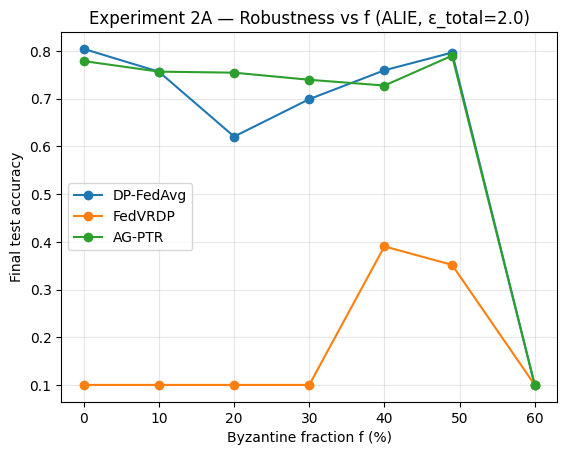

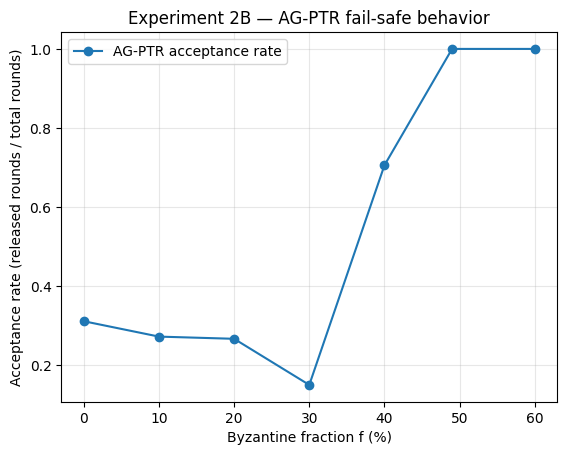

Saved exp2_results.csv


,f,dp_fedavg_acc,fedvrdp_acc,agptr_acc,agptr_accept_rate
0,0.00,0.8045,0.1000,0.7790,0.311111
1,0.10,0.7566,0.1000,0.7569,0.272222
2,0.20,0.6207,0.1000,0.7547,0.266667
3,0.30,0.6992,0.1000,0.7398,0.150000
4,0.40,0.7597,0.3905,0.7277,0.705556
5,0.49,0.7968,0.3517,0.7903,1.000000
6,0.60,0.1000,0.1000,0.1000,1.000000


In [14]:
# Cell 15 — FULL Experiment 2 sweep + required plots + CSV report [UPDATED]
seed = 0
eps_total = 2.0
delta = 1e-5

f_list = [0.00, 0.10, 0.20, 0.30, 0.40, 0.49, 0.60]

# Paper-like settings for FMNIST cross-device (adjust if too slow)
ROUNDS = 180
LOCAL_EPOCHS = 10
BATCH_SIZE = 10

# Shared training hyperparams
LR0 = 0.125
LR_DECAY = 0.99
MOMENTUM = 0.5

# Attack strength (constant across all f)
ALIE_Z = 2.0
ALIE_DIR = -1.0

# AG-PTR anchor settings (8–16 anchors recommended)
R = 8
PUB_BATCH = 20
PUB_SCALE = 0.1
PUBLIC_EPOCHS = 1

# AG-PTR gate/clipping (tune with short calibration if needed)
RHO = 0.79
TAU = 60

q = CLIENTS_PER_ROUND / NUM_CLIENTS

# Compute DP noise multipliers ONCE (ε_total fixed; depends on q, rounds, delta)
sigma_dp = find_sigma_for_target_eps_single(eps_total, q, ROUNDS, delta)
eps_dp = epsilon_from_sigma_single(sigma_dp, q, ROUNDS, delta)

sel_factor = 2.0
sigma_rel = find_sigma_rel_for_target_eps_two(eps_total, q, ROUNDS, delta, sel_factor=sel_factor)
sigma_sel = sel_factor * sigma_rel
eps_ag = epsilon_from_sigma_two(sigma_sel, sigma_rel, q, ROUNDS, delta)

print("DP-FedAvg/FedVRDP sigma:", sigma_dp, "achieved eps≈", eps_dp)
print("AG-PTR sig_sel/sig_rel:", sigma_sel, sigma_rel, "achieved eps≈", eps_ag)
print(f"AG-PTR anchors: R={R}, pub_batch={PUB_BATCH}, pub_scale={PUB_SCALE}, tau={TAU}, rho={RHO}")
print(f"ALIE constant-z: z={ALIE_Z}, direction={ALIE_DIR}")

dp_acc, ag_acc, vr_acc, ag_accept = [], [], [], []

for f in f_list:
    acc1 = train_dp_fedavg_robust(
        seed, eps_total, f, sigma_dp, delta=delta,
        rounds=ROUNDS, local_epochs=LOCAL_EPOCHS, batch_size=BATCH_SIZE,
        lr0=LR0, lr_decay=LR_DECAY, momentum=MOMENTUM,
        clip_C=1.0,
        alie_direction=ALIE_DIR, alie_z=ALIE_Z
    )

    acc2, ar = train_ag_ptr_robust(
        seed, eps_total, f, sigma_sel, sigma_rel, delta=delta,
        rounds=ROUNDS, local_epochs=LOCAL_EPOCHS, batch_size=BATCH_SIZE,
        lr0=LR0, lr_decay=LR_DECAY, momentum=MOMENTUM,
        rho=RHO, tau=TAU,
        R=R, pub_batch=PUB_BATCH, pub_scale=PUB_SCALE, public_epochs=PUBLIC_EPOCHS,
        alie_direction=ALIE_DIR, alie_z=ALIE_Z
    )

    acc3 = train_fedvrdp_robust(
        seed, eps_total, f, sigma_dp, delta=delta,
        rounds=ROUNDS, local_epochs=LOCAL_EPOCHS, batch_size=BATCH_SIZE,
        lr0=LR0, lr_decay=LR_DECAY, momentum=MOMENTUM,
        clip_C=1.0, k_frac=0.3,
        alie_direction=ALIE_DIR, alie_z=ALIE_Z
    )

    dp_acc.append(acc1)
    ag_acc.append(acc2)
    vr_acc.append(acc3)
    ag_accept.append(ar)

# Plot (A) accuracy vs f
plt.figure()
plt.plot([100*x for x in f_list], dp_acc, marker="o", label="DP-FedAvg")
plt.plot([100*x for x in f_list], vr_acc, marker="o", label="FedVRDP")
plt.plot([100*x for x in f_list], ag_acc, marker="o", label="AG-PTR (pub-only gate)")
plt.xlabel("Byzantine fraction f (%)")
plt.ylabel("Final test accuracy")
plt.title(f"Experiment 2A — Robustness vs f (ALIE const-z, ε_total={eps_total})")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Plot (B) acceptance rate vs f
plt.figure()
plt.plot([100*x for x in f_list], ag_accept, marker="o", label="AG-PTR acceptance rate")
plt.xlabel("Byzantine fraction f (%)")
plt.ylabel("Acceptance rate (released rounds / total rounds)")
plt.title("Experiment 2B — AG-PTR fail-safe behavior (public-only gate)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

df = pd.DataFrame({
    "f": f_list,
    "dp_fedavg_acc": dp_acc,
    "fedvrdp_acc": vr_acc,
    "agptr_acc": ag_acc,
    "agptr_accept_rate": ag_accept
})
df.to_csv("exp2_results.csv", index=False)
print("Saved exp2_results.csv")
df
